In [23]:
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp, Statevector

# BFGS minimizer routine
from qiskit_algorithms.optimizers import L_BFGS_B

# Plotting functions
import matplotlib.pyplot as plt

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

# Variational Quantum Eigensolver

The VQE is the first type of hybrid quantum--classical which was proposed, and it is the first one we will deal with. The cost function in this case based on the Ritz variational principle, that is

\begin{equation}
    C(\boldsymbol{\theta}) = \bra{\psi(\boldsymbol{\theta})}\mathcal{H}\ket{psi(\boldsymbol{\theta})}.
\end{equation}

The minimum of this function is the ground-state energy:

\begin{equation}
    E_0 = \min_{\boldsymbol{\theta}}\bra{\psi(\boldsymbol{\theta})}\mathcal{H}\ket{psi(\boldsymbol{\theta})}.
\end{equation}

We thus have the first component of our VQA, the cost function. Let us now define it in terms of code


In [17]:
def cost_function(theta, ansatz, hamiltonian):
	circuit = ansatz.assign_parameters(theta)  # bind parameters to circuit
	statevector = Statevector(circuit)  # get statevector representation
	exp = statevector.expectation_value(hamiltonian).real  # evaluation expectation value

	return exp

## Hamiltonian

Our next two components: the PQC and measurement strategy, may depend quite a bit on our Hamiltonian, and any constraints which we wish to satisfy (however for the sake of simplicity we will suppose that we have no extra constraints). However, for now we shall take statevector simulations, that is we assume that we have perfect information of the quantum state (we have access to its vector representation). Thus, we need not worry about the measurement technique yet. This is useful for prototyping your VQA, ensuring that everything works.

We shall take a simplified $H_2$ model at $0.735$Å, which can be written in Qiskit as

In [18]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

## Parameterized quantum circuit

Now let's proceed to use a simple two local ansatz, that is an ansatz which alternates between parameterized one-qubit gates, and (non-parameterized) two-qubit entangling gates

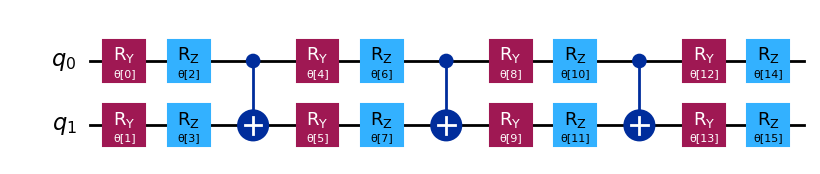

In [19]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

## Classical optimizer

As we said, for now shall focus on statevector simulations and not worry about measurements. The next step is then choose a classical optimizer. Qiskit has many optimizers to choose from. Quite a bit of them are based on Scipy's implementations. We will take the sequential least squares programming (SLSQP) optimizer for the time being

In [20]:
optimizer = L_BFGS_B(args=(ansatz, hamiltonian))  # extra arguments in the cost function need to be included

## Putting it all together

We now just need to run the algorithm optimizing through to get our ground-state energy

In [24]:
x0 = np.random.uniform(-np.pi, np.pi, len(ansatz.parameters))  # We need an initial point (which can be random)

result = optimizer.minimize(fun=cost_function, x0=x0)

print(result)

{   'fun': np.float64(-0.7029303944427259),
    'jac': None,
    'nfev': 221,
    'nit': 12,
    'njev': 13,
    'x': array([-0.18559226, -1.57289024,  2.01951134, -0.60420642, -3.08386443,
        1.87527889,  2.17975187,  0.62579538, -1.21227154, -3.23294541,
       -1.24902101, -0.92447977,  1.82165919,  2.27032634, -0.72741229,
       -2.73597372])}
